<a href="https://colab.research.google.com/github/gordoncd/time-series-summer2023/blob/main/time_series_stock_LSTM_06-29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [257]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
! pip install pandas_ta
import pandas_ta as ta
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import itertools


Now we want to load in our data, let's predict on google for the past 5 years

In [258]:
google = yf.Ticker("GOOGL")
google.history('5y').head()
data = yf.download("GOOGL", '2018-01-01', '2023-01-01')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000


Getting some technical indicators


In [259]:
data['RSI'] = ta.rsi(data.Close, length = 15)
data['EMAF'] = ta.ema(data.Close, length = 20)
data['EMAM'] = ta.ema(data.Close, length = 100)
data['EMAS'] = ta.ema(data.Close, length = 150)
data['Squeeze'] = ta.squeeze(data.High, data.Low, data.Close, length = 20)['SQZ_20_2.0_20_1.5']
data['inertia'] = ta.inertia(data.Close, data.High, data.Low, length = 20)
#can add other technical indicators

data['Target'] = data['Adj Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace = True)
data.reset_index(inplace= True)
data.drop(['Volume', 'Close', 'Date'], axis = 1, inplace = True)

In [260]:
data.head(10)

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Squeeze,inertia,Target,TargetClass,TargetNextClose
0,62.080502,62.123001,61.526501,61.883499,59.457146,61.015687,57.468140,55.813370,1.499416,49.261856,0.191502,1,62.792000
1,62.600498,63.304001,62.590000,62.792000,63.446509,61.184860,57.573563,55.905802,1.742583,48.422347,0.230503,1,63.066502
2,62.835999,63.585999,62.605999,63.066502,64.574960,61.364064,57.682334,56.000646,1.972000,49.045662,0.086498,1,63.223000
3,63.136501,63.598000,63.005001,63.223000,65.230618,61.541105,57.792050,56.096306,1.720583,50.952778,-0.333500,0,62.625500
4,62.959000,63.060001,62.358002,62.625500,60.639532,61.644381,57.887762,56.182785,1.291583,52.462380,-0.128002,0,62.431999
5,62.560001,63.298500,62.351501,62.431999,59.193931,61.719392,57.977747,56.265557,0.773999,52.294323,0.282001,1,62.907001
6,62.625000,63.029499,61.977001,62.907001,61.601526,61.832498,58.075356,56.353523,0.496333,53.607343,-0.603001,0,61.611000
7,62.214001,62.598999,61.312000,61.611000,52.539635,61.811403,58.145369,56.423158,0.031500,53.427347,-0.896500,0,61.202999
8,62.099499,62.185001,60.981499,61.202999,50.055920,61.753460,58.205916,56.486467,-0.414251,51.835910,-0.309502,0,60.792500
9,61.102001,61.347500,60.200001,60.792500,47.628758,61.661940,58.257135,56.543501,-0.609667,48.896366,0.064499,1,61.097500


In [261]:
data_set = data.iloc[:,0:13]
pd.set_option('display.max_columns', None)

In [262]:
sc = MinMaxScaler(feature_range = (0,1))
data_set_scaled = sc.fit_transform(data_set)

In [263]:
X = []

backcandles = 30
for j in range(10):
  X.append([])
  for i in range(backcandles, data_set_scaled.shape[0]):
    X[j].append(data_set_scaled[i-backcandles:i,j])

X = np.moveaxis(X, [0], [2])

X, yi = np.array(X), np.array(data_set_scaled[backcandles:,-3])

y=np.reshape(yi,(len(yi),1))
#shape very important here
print(X.shape, y.shape)

(1079, 30, 10) (1079, 1)


In [264]:
split_thresh = int(len(X)*.8)
print(split_thresh)

X_train, X_test = X[:split_thresh], X[split_thresh:]
y_train, y_test = y[:split_thresh], y[split_thresh:]

863


In [265]:
# Define the LSTM model
class CustomLSTM(nn.Module):
    def __init__(self, lstm_sizes):
        super(CustomLSTM, self).__init__()
        self.num_layers = len(lstm_sizes)
        self.lstm_layers = nn.ModuleList()
        for i, lstm_size in enumerate(lstm_sizes):
            input_size = 10 if i == 0 else lstm_sizes[i-1]
            self.lstm_layers.append(nn.LSTM(input_size=input_size, hidden_size=lstm_size, batch_first=True))
        self.dense = nn.Linear(lstm_sizes[-1], 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        output = x
        for i in range(self.num_layers):
            output, _ = self.lstm_layers[i](output)
        output = self.dense(output[:, -1, :])
        output = self.activation(output)
        return output

In [266]:

# Set the hyperparameters for grid search
lstm_sizes_list = [[150, 100], [200, 150, 100], [150,125,100]]
batch_sizes = [10, 15, 20, 30]
epochs = 30
delta_loss_threshold = 0.001
stop_epochs = 5


In [267]:
# Define the function for grid search
def grid_search(hyperparams, X_train, y_train):
    lstm_sizes, batch_size = hyperparams

    # Instantiate the model
    model = CustomLSTM(lstm_sizes)

    # Define the loss function
    criterion = nn.MSELoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters())

    # Convert the data to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)

    # Training loop
    prev_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss for monitoring
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

        # Check if the loss improvement is below the threshold
        if prev_loss - loss.item() < delta_loss_threshold:
            epochs_no_improve += 1
        else:
            epochs_no_improve = 0

        # Check if training should stop
        if epochs_no_improve == stop_epochs:
            print('Training stopped as the loss has not improved for {} epochs.'.format(stop_epochs))
            break

        prev_loss = loss.item()

    return model, hyperparams, loss.item()

In [268]:
# Perform grid search
best_model = None
best_loss = float('inf')
best_hyperparams = None

for lstm_sizes, batch_size in itertools.product(lstm_sizes_list, batch_sizes):
    hyperparams = [lstm_sizes, batch_size]
    print('Hyperparameters:', hyperparams)
    model, hyperparams, current_loss = grid_search(hyperparams, X_train, y_train)
    # Evaluate the model on validation set or using cross-validation
    # Update best_model, best_loss, and best_hyperparams if the current model performs better
    if current_loss < best_loss:
        best_loss = current_loss
        best_model = model
        best_hyperparams = hyperparams

    # Check if training should stop based on the best_loss
    if best_loss < delta_loss_threshold:
        print('Grid search stopped as the best loss is below the threshold.')
        break

# After grid search is complete, use the best_model for predictions or further analysis
print('Best Hyperparameters:', best_hyperparams)

Hyperparameters: [[150, 100], 10]
Epoch [1/30], Loss: 0.2217
Epoch [2/30], Loss: 0.2217
Epoch [3/30], Loss: 0.2217
Epoch [4/30], Loss: 0.2217
Epoch [5/30], Loss: 0.2217
Epoch [6/30], Loss: 0.2217
Training stopped as the loss has not improved for 5 epochs.
Hyperparameters: [[150, 100], 15]
Epoch [1/30], Loss: 0.1610
Epoch [2/30], Loss: 0.1232
Epoch [3/30], Loss: 0.0900
Epoch [4/30], Loss: 0.0600
Epoch [5/30], Loss: 0.0340
Epoch [6/30], Loss: 0.0172
Epoch [7/30], Loss: 0.0213
Epoch [8/30], Loss: 0.0320
Epoch [9/30], Loss: 0.0269
Epoch [10/30], Loss: 0.0173
Epoch [11/30], Loss: 0.0114
Epoch [12/30], Loss: 0.0097
Epoch [13/30], Loss: 0.0105
Epoch [14/30], Loss: 0.0118
Epoch [15/30], Loss: 0.0128
Epoch [16/30], Loss: 0.0131
Epoch [17/30], Loss: 0.0125
Training stopped as the loss has not improved for 5 epochs.
Hyperparameters: [[150, 100], 20]
Epoch [1/30], Loss: 0.1848
Epoch [2/30], Loss: 0.1444
Epoch [3/30], Loss: 0.1086
Epoch [4/30], Loss: 0.0756
Epoch [5/30], Loss: 0.0456
Epoch [6/30], 

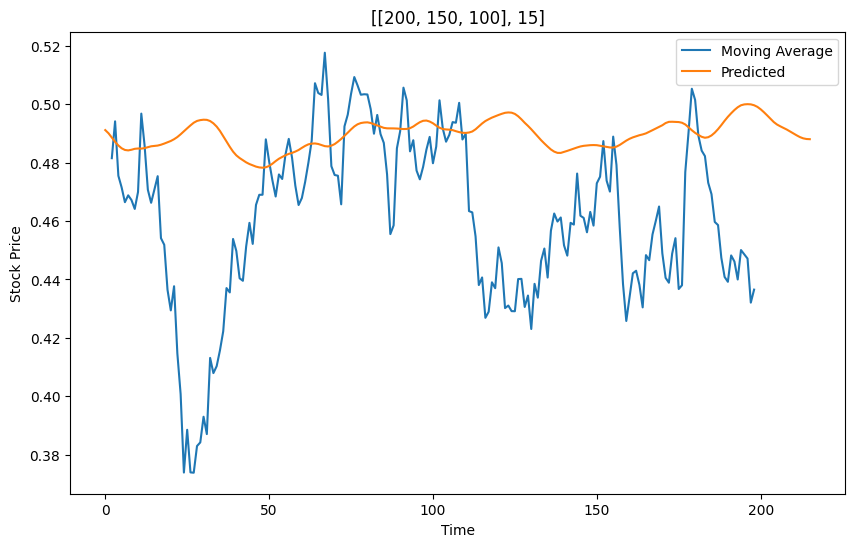

In [269]:
# Convert the testing data to torch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)

# Set the model to evaluation mode
best_model.eval()

# Make predictions on the testing data
with torch.no_grad():
    predictions = best_model(X_test)

# Convert the predictions to a numpy array
predictions = predictions.numpy()

# Calculate moving average of the test data
moving_average = np.convolve(y_test.flatten(), np.ones(20)/20, mode='valid')

#Plot the actual data, moving average, and predictions
plt.figure(figsize=(10, 6))
#plt.plot(y_test, label='Actual')
plt.plot(range(2, 2+len(moving_average)), moving_average, label='Moving Average')
plt.plot(predictions, label='Predicted')
plt.title(best_hyperparams)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
